# Simple iteration for systems of linear equations

First, generate a random diagonally dominant matrix, for testing.

In [2]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)

# I.  Jacobi iteration

Given

$$
A x = b
$$

separate the diagonal part $D$,

$$ A = D + (A - D) $$

and write

$$
x = D^{-1} (D - A) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = D^{-1} (A - D) \qquad \text{and} \qquad c = D^{-1} b
$$


Let's construct the matrix and the r.h.s. for the Jacobi iteration

In [3]:
diag_1d = np.diag(A)

B = -A.copy()
np.fill_diagonal(B, 0)

D = np.diag(diag_1d)
invD = np.diag(1./diag_1d)
BB = invD @ B 
c = invD @ b

In [4]:
# sanity checks
from numpy.testing import assert_allclose

assert_allclose(-B + D, A)


# xx is a "ground truth" solution, compute it using a direct method
xx = np.linalg.solve(A, b)

np.testing.assert_allclose(A@xx, b)
np.testing.assert_allclose(D@xx, B@xx + b)
np.testing.assert_allclose(xx, BB@xx + c)

Check that $\| B\| \leqslant 1$:

In [5]:
np.linalg.norm(BB)

0.36436161983015336

### Do the Jacobi iteration

In [6]:
n_iter = 50

x0 = np.ones(n)
x = x0
for _ in range(n_iter):
    x = BB @ x + c

In [7]:
# Check the result:

A @ x - b

array([ 0.00000000e+00,  2.22044605e-16,  0.00000000e+00, -1.11022302e-16,
        0.00000000e+00,  0.00000000e+00, -2.08166817e-17,  0.00000000e+00,
        0.00000000e+00,  2.22044605e-16])

### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


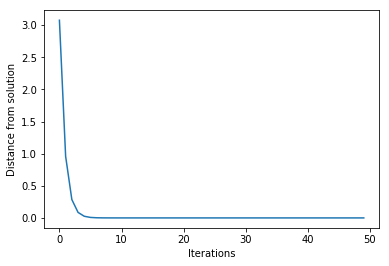

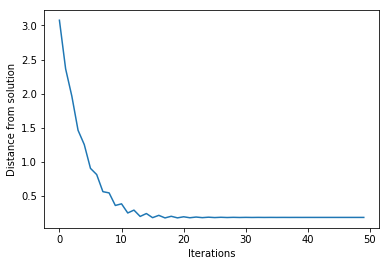

In [10]:
# ... ENTER YOUR CODE HERE ...
import matplotlib.pyplot as plt

def Jacobi_SLAE(A, b, iters=100):
    D_rev = np.diag(1./np.diag(A))
    B = -A.copy()
    np.fill_diagonal(B, 0)
    B = D_rev @ B
    B_norm = np.linalg.norm(B)
    
    assert B_norm <= 1, 'A is not diagonally dominant!'
    
    c = D_rev @ b
    x = np.ones(A.shape[1])
    
    for i in range(iters):
        x = B @ x + c
    
    return x

# xx - настоящее решение
xx = np.linalg.solve(A, b)

N = 50
differ = np.zeros(N)
Range = np.arange(N)

for i in range(N):
    Solution = Jacobi_SLAE(A, b, iters=i)
    differ[i] = np.linalg.norm(Solution - xx)

plt.xlabel('Iterations')
plt.ylabel('Distance from solution')

plt.plot(Range, differ)

#Давайте сделаем диагональные элементы поменьше:
A1 = rndm.uniform(size=(n, n)) + np.diagflat([6]*n)    #на значениях ниже 5, норма B выше 1, функция выдаст ошибку, хотя может какая-то норма до сих пор < 1
b1 = rndm.uniform(size=n)                              #строчку в функции можно закомментить, и увидеть что итерации расходятся, посмотрев на график

differ_1 = np.zeros(N)

for i in range(N):
    Solution = Jacobi_SLAE(A1, b1, iters=i)
    differ_1[i] = np.linalg.norm(Solution - xx)
    
plt.figure()
plt.xlabel('Iterations')
plt.ylabel('Distance from solution')
plt.plot(Range, differ_1)

# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

[ 0.38624826  0.1277473   0.20473288 -0.01603288 -0.2180493   0.44826824]
Norm of iteration matrix ||B|| =  1.3521098707069825


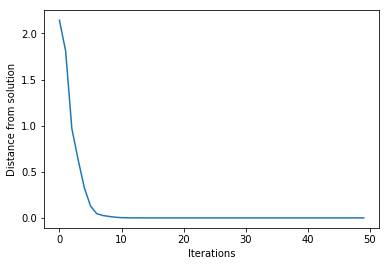

In [29]:
# ... ENTER YOUR CODE HERE ...

def Seidel_SLAE(A, b, iters=100):
    L = np.tril(A)
    U = np.triu(A, 1) #разделяем на нижнетреугольную, и строговерхнетреугольную
    
    x_old = np.ones(A.shape[1])
    x = x_old.copy()
    
    #следующие несколько строк - перевод в вид x = Bx + c, чтобы проверить норму итерационной матрицы B
    B = -np.linalg.inv(L) @ U
    Iter_norm = np.linalg.norm(B)
    
    for k in range(iters):
        for i in range(A.shape[0]):
            known_part = 0
            for j in range(i):
                known_part += x[j] * L[i,j]
            x[i] = (b[i] - U[i, :] @ x_old - known_part) / L[i, i]
        x_old[:] = x
        #print(x)
    
    return x, Iter_norm

s = 6
A_2 = rndm.uniform(size=(s, s)) + np.diagflat([1]*s)        #регулируя, насколько диагональ доминирует над другими элементами, можно 'дергать' норму B, и видеть скорость
b_2 = rndm.uniform(size=s)                                  #сходимости алг-ма, и сходится перестает совсем около ||B|| примерно 2.5 - 3.0

x_true = np.linalg.solve(A_2, b_2)
differ_2 = np.zeros(N)

print(x_true)

for i in range(N):
    Solution, norm = Seidel_SLAE(A_2, b_2, iters=i)
    differ_2[i] = np.linalg.norm(Solution - x_true)
    
plt.figure()
plt.xlabel('Iterations')
plt.ylabel('Distance from solution')
plt.plot(Range, differ_2)
print("Norm of iteration matrix ||B|| = ", norm)

# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

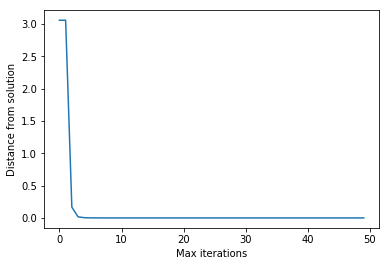

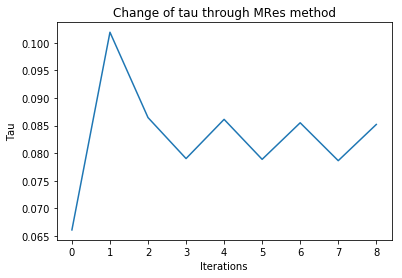

In [78]:
# ... ENTER YOUR CODE HERE ...

def MRes(A, b, maxiters=1000, tol=1e-5):
    n = b.shape[0]
    x = np.ones(n)
    res = b - np.dot(A, x)  #начальные приближения
    iters = 1
    Tau_history = []
    
    while np.linalg.norm(res) > tol and iters < maxiters:
        A_res = np.dot(A, res)
        tau = A_res @ res / ( A_res @ A_res )
        x += tau * res
        res = b - np.dot(A, x)
        iters += 1
        Tau_history.append(tau)
    
    return x, Tau_history, iters

size = 10
A_3 = rndm.uniform(size=(size, size)) + np.diagflat([10]*size) #при малой диагонали, перестает сходиться
b_3 = rndm.uniform(size=size)

# xxx - настоящее решение
xxx = np.linalg.solve(A_3, b_3)

differ_3 = np.zeros(N)

for i in range(N):
    Solution, Tau_history, iters = MRes(A_3, b_3, maxiters=i)
    differ_3[i] = np.linalg.norm(Solution - xxx)

plt.xlabel('Max iterations')
plt.ylabel('Distance from solution')
plt.plot(Range, differ_3)

plt.figure()
plt.xlabel('Iterations')
plt.ylabel('Tau')
plt.title('Change of tau through MRes method')
Iters = np.arange(iters - 1)
plt.plot(Iters, Tau_history) # похоже на осцилляции, которые релаксируют на определенном уровне к концу итераций